### 数据集处理

In [13]:
import pandas as pd 
import numpy as np

movement_data = pd.read_csv('./movement_libras.csv', header=None)
sonar_data = pd.read_csv('./sonar.csv', header=None)
wdbc_data = pd.read_csv('./wdbc.csv', header=None)

# 打乱数据
movement_data = movement_data.sample(frac=1.0)
sonar_data = sonar_data.sample(frac=1.0)
wdbc_data = wdbc_data.sample(frac=1.0)

# 特征、标签结果分离：
movement_future, movement_label = movement_data.iloc[:,:-1], movement_data.iloc[:,-1]
sonar_future, sonar_label = sonar_data.iloc[:,:-1], sonar_data.iloc[:,-1]
wdbc_future, wdbc_label = wdbc_data.iloc[:,:-1], wdbc_data.iloc[:,-1]

# 数据归一化
movement_norm = (movement_future - movement_future.min()) / (movement_future.max() - movement_future.min())
sonar_norm = (sonar_future - sonar_future.min()) / (sonar_future.max() - sonar_future.min())
wdbc_norm = (wdbc_future - wdbc_future.min()) / (wdbc_future.max() - wdbc_future.min())

# 数据划分
split_rate = 0.8
movement_train_future, movement_test_future = movement_future.iloc[:int(len(movement_future)*split_rate)], movement_future.iloc[int(len(movement_future)*split_rate):]
movement_train_label, movement_test_label = movement_label.iloc[:int(len(movement_label)*split_rate)], movement_label.iloc[int(len(movement_label)*split_rate):]

sonar_train_future, sonar_test_future = sonar_future.iloc[:int(len(sonar_future)*split_rate)], sonar_future.iloc[int(len(sonar_future)*split_rate):]
sonar_train_label, sonar_test_label = sonar_label.iloc[:int(len(sonar_label)*split_rate)], sonar_label.iloc[int(len(sonar_label)*split_rate):]

wdbc_train_future, wdbc_test_future = wdbc_future.iloc[:int(len(wdbc_future)*split_rate)], wdbc_future.iloc[int(len(wdbc_future)*split_rate):]
wdbc_train_label, wdbc_test_label = wdbc_label.iloc[:int(len(wdbc_label)*split_rate)], wdbc_label.iloc[int(len(wdbc_label)*split_rate):]

### 差分进化算法

In [14]:
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm 
bayes_modle=GaussianNB()

class Differential_Evolution:
    def __init__(self, train_data, train_result, test_data, test_result):
        self.train_data = train_data.to_numpy()
        self.train_result = train_result.tolist()
        self.test_data = test_data.to_numpy()
        self.test_result = test_result.tolist()
        self.num_of_future = self.train_data.shape[1]
        self.population_size = 20   # 种群规模
        self.retain_nums = 8        # 最优个体保留个数
        self.prob_cross = 0.7       # 交叉配对率
        self.prob_mutation = 0.1    # 变异率
        self.population = np.random.randint(0,2, size=(self.population_size,self.num_of_future))  # 初始化种群
        self.fitness_list = []      # 初始化适应度列表
        self.code_prob_list = np.ones(self.num_of_future) # 编码概率列表
        self.history = [] # 迭代历史记录

    def cal_fitness(self):          # 计算适应度
        fitness_list = []
        for each in self.population:
            bayes_modle.fit(self.train_data[:, [i for i in range(len(each)) if each[i] == 1]], self.train_result)
            fitness_list.append(bayes_modle.score(self.test_data[:,[i for i in range(len(each)) if each[i] == 1]], self.test_result))
        self.fitness_list = fitness_list
    
    def selection(self):           # 根据适应度选择排名靠前的个体
        new_population = self.crossover_and_mutation() # 初始化第二代种群
        self.population = self.population[np.argsort(self.fitness_list)[::-1]] # 根据个体适应度进行排序
        new_population[:self.retain_nums] = self.population[:self.retain_nums]
        for i in range(self.population.shape[1]):
            self.code_prob_list[i] = sum(new_population[:,i])/self.retain_nums

        for j in range(self.retain_nums, self.population_size):
            for index in range(len(new_population[j])):
                prob = np.random.rand()
                if prob <= self.code_prob_list[index]:
                    new_population[j][index] = 1
                else:
                    new_population[j][index] = 0

        self.population = new_population
    
    def crossover_and_mutation(self):           # 交叉与变异
        cross_prob_list = np.random.rand(self.population_size)
        new_population = np.zeros((self.population_size,self.num_of_future))
        for i in range(self.population_size):
            if cross_prob_list[i] < self.prob_cross:
                cross_prob_list[i] = 1.
            else:
                cross_prob_list[i] = 0.
        cross_list = np.where(cross_prob_list == 1.)[0]
        if len(cross_list) % 2: cross_list = cross_list[:-1]
        for index in range(int(len(cross_list)/2)):
            cross_point = np.random.randint(0,self.num_of_future)
            new_population[cross_list[index*2], cross_point], self.population[cross_list[index*2+1], cross_point] = self.population[cross_list[index*2+1], cross_point], self.population[cross_list[index*2], cross_point]

        mutation_prob_list = np.random.rand(self.population_size)
        for i in range(self.population_size):
            if mutation_prob_list[i] < self.prob_mutation:
                mutation_prob_list[i] = 1.
            else:
                mutation_prob_list[i] = 0
        mutation_list = np.where(mutation_prob_list == 1.)[0]
        for each in mutation_list:
            mutation_point = np.random.randint(0,self.num_of_future)
            new_population[each, mutation_point] = 0 if new_population[each, mutation_point] == 1 else 1
        return new_population

    def run(self):
        pbar = tqdm(range(200), ncols=100, total=200) # 进度条
        for each in pbar:
            self.cal_fitness()
            self.history.append(max(self.fitness_list))
            pbar.set_postfix(best_fitness = '{0:.4f}'.format(max(self.fitness_list)))
            self.selection()
        self.history.append(max(self.fitness_list))
        print(max(self.fitness_list))

In [15]:
de_movement1 = Differential_Evolution(movement_train_future, movement_train_label, movement_test_future, movement_test_label)
de_movement2 = Differential_Evolution(movement_train_future, movement_train_label, movement_test_future, movement_test_label)
de_movement3 = Differential_Evolution(movement_train_future, movement_train_label, movement_test_future, movement_test_label)

de_movement1.run()
de_movement2.run()
de_movement3.run()

de_sonar1 = Differential_Evolution(sonar_train_future, sonar_train_label, sonar_test_future, sonar_test_label)
de_sonar2 = Differential_Evolution(sonar_train_future, sonar_train_label, sonar_test_future, sonar_test_label)
de_sonar3 = Differential_Evolution(sonar_train_future, sonar_train_label, sonar_test_future, sonar_test_label)

de_sonar1.run()
de_sonar2.run()
de_sonar3.run()

de_wdbc1 = Differential_Evolution(wdbc_train_future, wdbc_train_label, wdbc_test_future, wdbc_test_label)
de_wdbc2 = Differential_Evolution(wdbc_train_future, wdbc_train_label, wdbc_test_future, wdbc_test_label)
de_wdbc3 = Differential_Evolution(wdbc_train_future, wdbc_train_label, wdbc_test_future, wdbc_test_label)

de_wdbc1.run()
de_wdbc2.run()
de_wdbc3.run()

100%|████████████████████████████████████████| 200/200 [00:07<00:00, 26.16it/s, best_fitness=0.6806]


0.6805555555555556


100%|████████████████████████████████████████| 200/200 [00:07<00:00, 25.11it/s, best_fitness=0.7083]


0.7083333333333334


100%|████████████████████████████████████████| 200/200 [00:07<00:00, 26.27it/s, best_fitness=0.6528]


0.6527777777777778


100%|████████████████████████████████████████| 200/200 [00:03<00:00, 54.44it/s, best_fitness=0.8571]


0.8571428571428571


100%|████████████████████████████████████████| 200/200 [00:03<00:00, 55.36it/s, best_fitness=0.9286]


0.9285714285714286


100%|████████████████████████████████████████| 200/200 [00:03<00:00, 55.98it/s, best_fitness=0.8571]


0.8571428571428571


100%|████████████████████████████████████████| 200/200 [00:03<00:00, 55.04it/s, best_fitness=0.9649]


0.9649122807017544


100%|████████████████████████████████████████| 200/200 [00:03<00:00, 53.34it/s, best_fitness=0.9561]


0.956140350877193


100%|████████████████████████████████████████| 200/200 [00:03<00:00, 54.42it/s, best_fitness=0.9561]

0.956140350877193


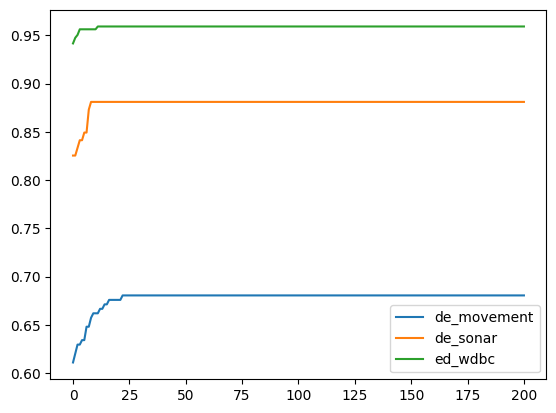

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

de_movement = (np.array(de_movement1.history)+np.array(de_movement2.history)+np.array(de_movement3.history))/3
de_sonar = (np.array(de_sonar1.history)+np.array(de_sonar2.history)+np.array(de_sonar3.history))/3
de_wdbc = (np.array(de_wdbc1.history)+np.array(de_wdbc2.history)+np.array(de_wdbc3.history))/3
plt.plot(de_movement, label='de_movement')
plt.plot(de_sonar, label="de_sonar")
plt.plot(de_wdbc, label="ed_wdbc")
plt.legend(loc='lower right')
plt.show()

### 前馈神经网络算法

In [17]:
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as Data

# 构造前馈神经网络
class FNN(nn.Module):  
    def __init__(self, num_of_feature, num_of_classes):
        super(FNN, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(num_of_feature, 200),
            nn.ReLU(),
            nn.Linear(200,200),
            nn.ReLU(),
            nn.Linear(200,num_of_classes),
        )

    def forward(self, X):
        output = self.linear(X)
        return output

# 模型训练函数
def model_train(train_future, train_label, test_future, test_label, num_of_classes):
    # 训练参数
    batch_size = 20
    epoch = 200
    learning_rate = 0.001

    model = FNN(train_future.shape[1], num_of_classes)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = torch.nn.CrossEntropyLoss()
    train_loss_his = []
    test_his = []

    # 数据导入与标准化
    datasets = Data.TensorDataset(torch.from_numpy(train_future.values.astype(np.float32)), torch.from_numpy(train_label.values))
    train_loader = Data.DataLoader(dataset=datasets, batch_size=batch_size, shuffle=True)

    for epoch_now in range(epoch):
        pbar = tqdm(enumerate(train_loader), ncols=100, total=len(train_loader)) # 进度条
        for step, (x, y) in pbar:
            x = x.cuda()
            y = y.cuda()
            model.train()
            output = model(x)

            loss = loss_func(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_his.append(loss.data.cpu())
            pbar.set_description(f"EPOCH {epoch_now}/{epoch}")
            pbar.set_postfix(loss = '{0:.2f}'.format(loss.data.cpu()), output = '{0:.2f}'.format(output[0].tolist().index(max(output.cpu()[0]))), real = '{0:.2f}'.format(y.cpu()[0]))
        test_his.append(model_test(model, test_future, test_label))
    return(test_his)

def model_test(model, test_futures, test_labels):
    right = 0
    output = model(torch.from_numpy(test_futures.values.astype(np.float32)).cuda())
    for i in range(len(test_futures)):
        if output[i].tolist().index(max(output[i].cpu())) == test_labels.values[i]:right+=1
    return right/len(test_futures)



In [18]:
fnn_movement1 = model_train(movement_train_future, movement_train_label, movement_test_future, movement_test_label, 15)
fnn_movement2 = model_train(movement_train_future, movement_train_label, movement_test_future, movement_test_label, 15)
fnn_movement3 = model_train(movement_train_future, movement_train_label, movement_test_future, movement_test_label, 15)

fnn_sonar1 = model_train(sonar_train_future, sonar_train_label, sonar_test_future, sonar_test_label, 2)
fnn_sonar2 = model_train(sonar_train_future, sonar_train_label, sonar_test_future, sonar_test_label, 2)
fnn_sonar3 = model_train(sonar_train_future, sonar_train_label, sonar_test_future, sonar_test_label, 2)

fnn_wdbc1 = model_train(wdbc_train_future, wdbc_train_label, wdbc_test_future, wdbc_test_label, 2)
fnn_wdbc2 = model_train(wdbc_train_future, wdbc_train_label, wdbc_test_future, wdbc_test_label, 2)
fnn_wdbc3 = model_train(wdbc_train_future, wdbc_train_label, wdbc_test_future, wdbc_test_label, 2)

EPOCH 199/200: 100%|████████████| 23/23 [00:00<00:00, 218.21it/s, loss=0.34, output=1.00, real=1.00]


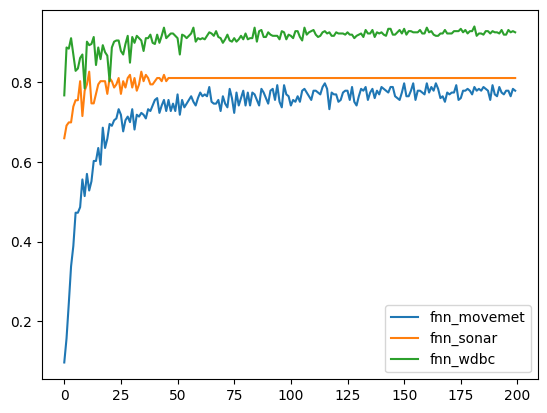

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

fnn_movement = (np.array(fnn_movement1)+np.array(fnn_movement2)+np.array(fnn_movement3))/3
fnn_sonar = (np.array(fnn_sonar1)+np.array(fnn_sonar2)+np.array(fnn_sonar3))/3
fnn_wdbc = (np.array(fnn_wdbc1)+np.array(fnn_wdbc2)+np.array(fnn_wdbc3))/3
plt.plot(fnn_movement, label='fnn_movemet')
plt.plot(fnn_sonar, label="fnn_sonar")
plt.plot(fnn_wdbc, label="fnn_wdbc")
plt.legend(loc='lower right')
plt.show()

### 结果对比

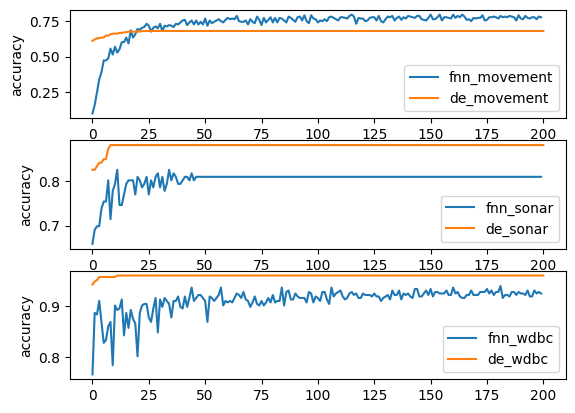

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.subplot(3,1,1)
plt.plot(fnn_movement, label='fnn_movement')
plt.plot(de_movement, label='de_movement')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.subplot(3,1,2)
plt.plot(fnn_sonar, label="fnn_sonar")
plt.plot(de_sonar, label="de_sonar")
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.subplot(3,1,3)
plt.plot(fnn_wdbc, label="fnn_wdbc")
plt.plot(de_wdbc, label="de_wdbc")
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()